<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Identificación de huellas de calzado a partir de imágenes con redes neuronales convolucionales </p>
<p style="margin: 0; text-align:right;">MU Ingeniería Computacional y Matemática / Área de Inteligencia Artificial</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Laura Rivera Sanchez</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>



# Identificación de huellas de calzado a partir de imágenes con redes neuronales convolucionales 

El objetivo de este cuaderno es, a parte de la creación y entrenamiento de un red neuronal capaz de determinar la marca de calzado de una huella a partir de los datos disponibles. Se realizan diferentes experimentos con diferentes parámetros y procesos para analizar los resultados y poder concluir si éstas pueden dar un resultado satisfactorio.

Con este proyecto se quiere dar respuesta a las siguientes preguntas o hipótesis mediante los experimentos:
1.	¿Qué preprocesado de imágenes funciona mejor?
2.	¿Utilizar más epochs, resulta siempre en mejor resultado?
3.	¿Un mayor tamaño de las imágenes utilizadas, resulta en un mejor resultado?
4.	¿Cuál es el mínimo de muestras por marcas aceptable para el modelo?




In [17]:
#librerias necesarias:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2 
import random
import skimage

In [4]:
#En caso de utilizar google colab:
#from google.colab import drive
#drive.mount('/content/gdrive')

# Lectura y análisis de los conjuntos de datos






In [2]:



def get_images_to_jpeg(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []

  for f in dir_list:

    im = Image.open("./"+imgPath+"/"+f)
    im2=im.resize((400,912))
    im3 = im2.crop((40,40,320,872)) #Quitar marco medidor
    im3.save("./"+imgPath+"/"+f[0:-4]+'jpeg')
    
    result.append(f[0:-4]+'jpeg')
    os.remove("./"+imgPath+"/"+f)

  print('Nº files:',len(result))
  return result

def get_images(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []
  for f in dir_list:  
    result.append(f)


  print('Nº files:',len(result))
  return result

## Base de datos Datos FD-300


In [ ]:
#Extracción de los ficheros del zip
with ZipFile('data/FID300/images.zip', 'r') as zipObj:
  zipObj.extractall('fid300')

In [3]:
#Lectura de la tabla de resultados
df_fid300 = pd.read_csv('data/FID300/label_table.csv', delimiter=',')

En este caso, las imágenes estan divididas en 3 carpetas:

*   *tracks_original*: Conteine las 300 imágenes originales extraidas de la escena del crimen, incluyendo la plantilla de medición.
*   *tracks_cropped*: Contiene las imágenes originales pero ya recortadas.
*  *references*: Contiene las 1175 imágenes de las huellas de referencia, obtenidas de diferentes calzados.

Para el proyecto se decide utilizar las dos últimas categorias, guardandolas en 2 datasets diferenciados: *fid300ref* y *fid300crop*.


**Análisis de los datos FD-300**



In [4]:
fid300ref = get_images("fid300/references")
fid300crop = get_images("fid300/tracks_cropped")

print(len(df_fid300)) #lineas en el csv
print(fid300ref[0])

Nº files: 1175
Nº files: 300
300
00481.png


In [5]:

X_files = df_fid300['X'].values.tolist()
y = df_fid300['y'].values.tolist()

values_y, counts_y = np.unique(y, return_counts=True)

print('Nº of references: %d' %len(values_y))

dfref = pd.DataFrame({'x':values_y, 'y':counts_y}) 
dfref = dfref.sort_values('y', ascending = False) 
dfref.head(10) # coger los 5 primeros



Nº of references: 130


,x,y
32,37,7
19,22,6
2,3,6
4,5,6
44,49,6
12,14,6
89,1055,6
79,1041,5
55,60,5
9,11,5


### Visualización de imágenes

Se ha creado la función *plot_image* que permite la visualización de las imágenes de cualquiera de las dos bases de datos.

Parámetros:\
*imgPath*: carpeta donde estan las imágenes \
*fileNames*: array con los nombres de los ficheros a mostrar


In [6]:

import skimage
def plot_image(imgPath, fileNames):
  for i in range(len(fileNames)):
    filename = fileNames[i]
    img = skimage.io.imread(imgPath+filename)
   
    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img)
  print(fileNames)
  plt.show()

def plot_image2(img):

    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img)

    plt.show()
def plot_image_grey(img):

    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img, cmap='gray')

    plt.show()

A continuación, se muestra una imagen aleatória de cada uno de los 3 datasets del proyecto:

['00462.png']


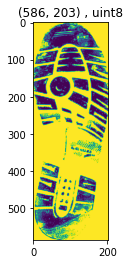

['00203.jpg']


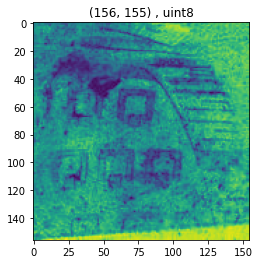

In [7]:

plot_image("fid300/references/",random.choices(fid300ref,k=1))
plot_image("fid300/tracks_cropped/",random.choices(fid300crop,k=1))


## División de los datos

Para la división de los datos se ha utilizado la funcióon train_test_split dos veces, primero para dividir entre el 80% de train y el 20% de test y después para extraer el equivalente al 10% para la validación. 

De esta manera se dispone de 70% train, 20% test y 10% validación.


Antes de dividir los datos de la base de datos 2d Footwear, se ha formateado la tabla ya que actualmente solo muestra la información de marca según el calzado del usuario, pero no contiene el nombre de la imagen, se ha creado la siguiente función para que el conjunto de datos contenga dos columnas (X:fichero, y:marca)

In [11]:
def checkBalancedSample(train, test, val):
    checkTest = False
    checkVal = False
    
    #Comprobar si existen en train
    test_in = test.y.isin(train.y).astype(int)
    val_in=val.y.isin(train.y).astype(int)

    #Comprobar que existen todos (todo 1)  
    if all(x==1 for x in test_in):
        checkTest = True
    if all(x==1 for x in val_in):
        checkVal = True
    #Devuelve True si en test y val aparecen marcas que existen en train:
    if checkTest and checkVal:
        return True
    return False

In [8]:
from sklearn.model_selection import train_test_split
def  split_datafiles(df, val = True):
    
    X_train, X_test = train_test_split(df, test_size=0.2 , random_state=random.randint(0,32),shuffle=True)
    if val == False:
        return X_train,  X_test 
    else:
        X_train, X_val = train_test_split(X_train, test_size=0.14, random_state=random.randint(0,32),shuffle=True) # 0.14 x 0.7 = 0.1
        return X_train,  X_test ,X_val

#Dividir conjunto de datos:
#shoes_train, shoes_test, shoes_val = split_datafiles(df)
shoes_train, shoes_test = split_datafiles(df_shoe_brand, False)


    

NameError: name 'df_shoe_brand' is not defined

In [100]:
#división de los datos FD300





# Objetivo 2: Búsqueda de similitud (FD300) First try

Red neuronal siamesa para la búsqueda de imágenes similares.

https://github.com/luchonaveiro/image-search-engine/blob/master/02_Train_Autoencoder.ipynb

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Input, Dense, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pickle
import pandas as pd
import tensorflow as tf

# Load images
img_height = 586
img_width = 156
channels = 1 #3 
batch_size = 16

def my_preprocessing_function(img):
    
    #Combines all the transformations
    #img = cv.imread('fid300/'+filename)
    #img = rgb2gray(img)
    test_binary_high,img = cv.threshold(img,0, 255, cv2.THRESH_BINARY)
    #img = crop_image(img)
    #img = cv2.resize(img, (img_height, img_width), interpolation = cv2.INTER_AREA)
    img = np.expand_dims(img,-1)
   # img = gray2rgb(img)
    return img

 

train_datagen = ImageDataGenerator(preprocessing_function =my_preprocessing_function, rescale=1./255,
                                   validation_split=0.2)

#añadir funcion preprocessing_function para pasar a gris y binary
training_set = train_datagen.flow_from_directory(
    'fid300/',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     classes=['references'],
     class_mode = 'input',
     subset = 'training',
     color_mode='grayscale',
     shuffle=True)

validation_set = train_datagen.flow_from_directory(
    'fid300/',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     classes=['references'],
     subset = 'validation',
     class_mode = 'input',
     color_mode='grayscale',
     shuffle=False)

#Única clase porque no tengo classes / labels por imagen.

Found 940 images belonging to 1 classes.
Found 235 images belonging to 1 classes.


In [18]:
# Define the autoencoder
input_model = Input(shape=(img_height, img_width, channels))

print(input_model.shape)
# Encoder layers
encoder = Conv2D(32, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(encoder)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder_dim = K.int_shape(encoder)
encoder = Flatten()(encoder)

# Latent Space
latent_space = Dense(16, name='latent_space')(encoder)

# Decoder Layers
decoder = Dense(np.prod(encoder_dim[1:]))(latent_space)
decoder = Reshape((encoder_dim[1], encoder_dim[2], encoder_dim[3]))(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(32, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(1, (3, 3), padding="same")(decoder)
output = Activation('sigmoid', name='decoder')(decoder)

print(output.shape)

(None, 586, 156, 1)
(None, 586, 156, 1)


In [19]:
# Create model object
autoencoder = Model(input_model, output, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 586, 156, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 586, 156, 64)      640       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 586, 156, 64)      0         
                                                                 
 batch_normalization_8 (Batc  (None, 586, 156, 64)     256       
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 5850624)           0         
                                                                 
 latent_space (Dense)        (None, 16)                93610000  
                                                       

In [20]:
!pip install opencv-contrib-python==4.4.0.44 


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [22]:


# Compile the model
autoencoder.compile(loss="mse", optimizer= Adam(learning_rate=1e-3), metrics=['accuracy'])
#autoencoder.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])
# Fit the model
history = autoencoder.fit(
          training_set,
          steps_per_epoch=training_set.n // batch_size,
          epochs=25,
          validation_data=validation_set,
          validation_steps=validation_set.n // batch_size,
          callbacks = [ModelCheckpoint('models/image_autoencoder_2.h5', 
                                      monitor='val_loss', 
                                      verbose=0, 
                                      save_best_only=True, 
                                      save_weights_only=False)])



Epoch 1/25
58/58 [==============================] - 643s 11s/step - loss: 0.1348 - accuracy: 0.8717 - val_loss: 0.9292 - val_accuracy: 0.0597
Epoch 2/25
58/58 [==============================] - 601s 10s/step - loss: 0.0996 - accuracy: 0.9018 - val_loss: 0.7845 - val_accuracy: 0.1832
Epoch 3/25
58/58 [==============================] - 603s 10s/step - loss: 0.0924 - accuracy: 0.9069 - val_loss: 0.1121 - val_accuracy: 0.8877
Epoch 4/25
58/58 [==============================] - 603s 10s/step - loss: 0.0646 - accuracy: 0.9353 - val_loss: 0.0610 - val_accuracy: 0.9374
Epoch 5/25
58/58 [==============================] - 601s 10s/step - loss: 0.0386 - accuracy: 0.9614 - val_loss: 0.0103 - val_accuracy: 0.9911
Epoch 6/25
58/58 [==============================] - 604s 10s/step - loss: 0.0223 - accuracy: 0.9779 - val_loss: 0.0097 - val_accuracy: 0.9911
Epoch 7/25
58/58 [==============================] - 609s 11s/step - loss: 0.0129 - accuracy: 0.9868 - val_loss: 0.0091 - val_accuracy: 0.9911
Epoch 

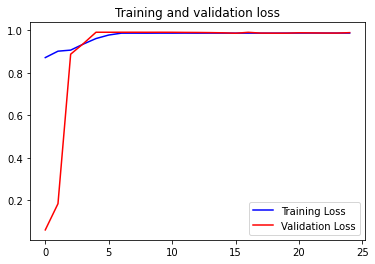

In [23]:
# Plot Accuracy and Loss
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
 
epochs = range(len(loss))
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [24]:
# Predict image function
def predict_image(image_dir, autoencoder):
  raw_image = load_img(image_dir, target_size=(img_height, img_width), color_mode = "grayscale")
  image = img_to_array(raw_image)
  image = np.expand_dims(image, axis=0)
  image = image / 255.0
  pred = autoencoder.predict(image)
  pred = pred * 255.0
  pred = np.reshape(pred, (img_height, img_width, 1))
  pred = array_to_img(pred)

  return raw_image, pred



1/1 [==============================] - 1s 611ms/step


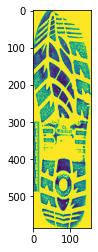

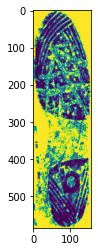

1/1 [==============================] - 0s 347ms/step


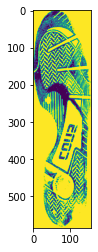

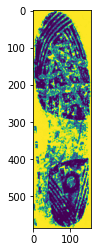

1/1 [==============================] - 0s 341ms/step


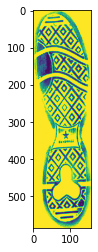

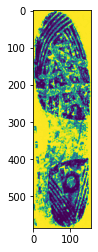

In [25]:
# Predict 3 images from training set
train_imgs = training_set.filepaths[0:3]

for i in train_imgs:
  raw_image, pred_image = predict_image(i, autoencoder)
  
  # Show original image
  plt.imshow(raw_image)
  plt.show()
  
  # Show predicted image
  plt.imshow(pred_image)
  plt.show()

In [28]:
autoencoder.save('models/image_autoencoder_2.h5')

In [36]:
import os
#Latent space:

autoencoder = load_model('models/image_autoencoder_2.h5', compile=False)
latent_space_model = Model(autoencoder.input, autoencoder.get_layer('latent_space').output)

#
# Load all images and predict them with the latent space model
X = []
indices = []

for i in tqdm(range(len(os.listdir('./fid300/references')))):
  try:
    img_name = os.listdir('./fid300/references')[i]
    img = load_img('./fid300/references/{}'.format(img_name), 
                   target_size = (img_height, img_width), color_mode = "grayscale")
    img = img_to_array(img) / 255.0
    test_binary_high,img = cv.threshold(img,0, 255, cv2.THRESH_BINARY)
    #img = crop_image(img)
    #img = cv2.resize(img, (img_height, img_width), interpolation = cv2.INTER_AREA)
    #img = np.expand_dims(img,-1)
    
    #img = cv2.resize(img, (img_height, img_width), interpolation = cv2.INTER_AREA)
    img = np.expand_dims(img, axis=0)
    pred = latent_space_model.predict(img)
    pred = np.resize(pred, (16))
    X.append(pred)
    indices.append(img_name)

  except Exception as e:
    print(img_name)
    print(e)

    # Export the embeddings
embeddings = {'indices': indices, 'features': np.array(X)}
pickle.dump(embeddings, 
            open('./fid300/image_embeddings.pickle', 'wb'))
#
def eucledian_distance(x,y):
  eucl_dist = np.linalg.norm(x - y)
  return eucl_dist



<ipython-input-36-9c544d3ff1c6>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(os.listdir('./fid300/references')))):


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 57ms/step



In [37]:
# Load embeddings
embeddings = pickle.load(open('./fid300/image_embeddings.pickle', 'rb'))

# Load images metadata
metadata = pd.read_csv('data/FID300/label_table.csv')

In [44]:
def getTop3Similars(img):
    # Calculate eucledian distance
    img_similarity = []
    #cat_similarity = []

    # Get actual image embedding
    
    #img = np.expand_dims(img, axis=0)

    img = img_to_array(img) / 255.0
    test_binary_high,img = cv.threshold(img,0, 255, cv2.THRESH_BINARY)
    img = np.expand_dims(img, axis=0)
    #img = my_preprocessing_function(img)
    #img = cv2.resize(img, (img_height, img_width), interpolation = cv2.INTER_AREA)
    #img = img_to_array(img) / 255.0
    #img = np.expand_dims(img, axis=0)

    pred = latent_space_model.predict(img)
    pred = np.resize(pred, (16))
    #ref_image = metadata.query("X == '{}'".format(int(img_name.replace('.jpg',''))))['y'].values[0]
    #print('Image Category: {}'.format(img_cat))

    for i in tqdm(range(len(embeddings['indices']))):
      img_name = embeddings['indices'][i]

      # Calculate vectors distances
      dist = eucledian_distance(pred,embeddings['features'][i])
      img_similarity.append(dist)

      # Calculate categoy similarity
      #cat = metadata.query("id == '{}'".format(img_name.replace('.jpg','')))['category'].values[0]
      #cat_sim = category_similarity(img_cat, cat)
      #cat_similarity.append(cat_sim)

    imgs_result = pd.DataFrame({'img': embeddings['indices'],
                                'euclidean_distance': img_similarity})


    imgs_result = imgs_result.query('euclidean_distance > 0').sort_values(by='euclidean_distance', ascending=True).reset_index(drop=True)
    #imgs_result = imgs_result.iloc[0:20,:].sort_values(by='category_similarity', ascending=False).reset_index(drop=True)

    # Show 3 first similar images
    for i in range(3):
      image = load_img('./fid300/references/{}'.format(imgs_result['img'].values[i]))
      #category = metadata.query("id == '{}'".format(imgs_result['img'].values[i].replace('.jpg','')))['category'].values[0]

      # Show image
      plt.imshow(image)
      plt.show()
      print('Image Name: {}'.format(imgs_result['img'].values[i]))
      print('Euclidean Distance: {}'.format(imgs_result['euclidean_distance'].values[i]))
      #print('Category Distance: {}'.format(imgs_result['category_similarity'].values[i]))

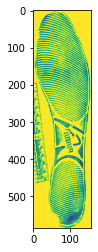

In [45]:
# Get image name
img_name = os.listdir('./fid300/references')[random.randint(0, 299)]
test1 = load_img('./fid300/references/{}'.format(img_name), 
                   target_size = (img_height, img_width), color_mode='grayscale')

#my_preprocessing_function(img)

plt.imshow(test1)

1/1 [==============================] - 0s 131ms/step


<ipython-input-44-38f05a565481>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


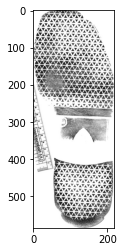

Image Name: 00948.png
Euclidean Distance: 1848.8782958984375


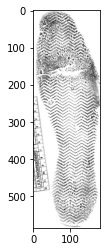

Image Name: 01152.png
Euclidean Distance: 1976.3292236328125


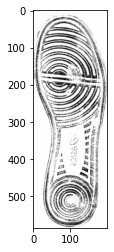

Image Name: 01091.png
Euclidean Distance: 2118.91748046875


In [46]:
getTop3Similars(test1)

Testing image: 204 Suggested solution: 12


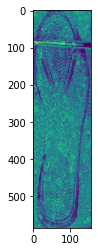

In [78]:
import re
# Get image name
img_name = os.listdir('./fid300/tracks_cropped')[random.randint(0, 299)]
test2 = load_img('./fid300/tracks_cropped/{}'.format(img_name), 
                   target_size = (img_height, img_width), color_mode='grayscale')

plt.imshow(test2)
code = re.sub("^0+(?!$)","",img_name[0:5])

solution = df_fid300[df_fid300.X == int(code)]
print ("Testing image: "+ code + " Suggested solution: "+str(solution['y'].iloc[0]))

1/1 [==============================] - 0s 74ms/step


<ipython-input-44-38f05a565481>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


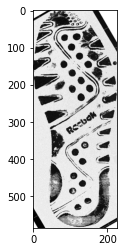

Image Name: 00017.png
Euclidean Distance: 20625.0


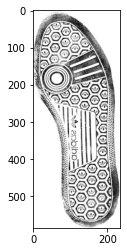

Image Name: 00109.png
Euclidean Distance: 24746.306640625


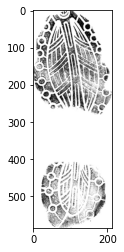

Image Name: 00639.png
Euclidean Distance: 27435.091796875


In [79]:
getTop3Similars(test2)

# Analisis de resultados


#https://pypi.org/project/tabulate/


